In [ ]:
import torch
import torch.nn as nn

import seaborn as sns
sns.set_theme()

import joblib
import json
import csv
from datetime import datetime

from models.acnh_model import ACNHModel

/Users/rainalex/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


LOAD DATA\
Data is already shuffled\
y files are already scaled (see 04_preprocessing.ipynb)

In [2]:
X_train, X_test, y_train, y_test = joblib.load('./data/preprocessed/train_test_data.pkl')

# Convert to tensors

In [3]:
X_train = torch.LongTensor(X_train)
X_test = torch.LongTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)


# Load embedding sizes

In [4]:
emb_sizes = joblib.load("data/preprocessed/embedding_sizes.pkl")

# Model Definition

In [5]:
# SET RANDOM SEED
torch.manual_seed(2)

In [6]:
model = ACNHModel(out_features=1, emb_sizes=emb_sizes, layers=[100, 50], drop_p=0.4)

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
model

ACNHModel(
  (embed): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(3, 1)
    (2-3): 2 x Embedding(15, 7)
    (4): Embedding(16, 8)
    (5): Embedding(6, 3)
    (6): Embedding(3, 1)
    (7): Embedding(7, 3)
    (8): Embedding(3, 1)
  )
  (embed_drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

## Model Training

In [9]:
def train(model, x_train, y_train, x_test, y_test, epochs=300):
    losses = []
    val_losses = []

    for i in range(epochs):

        train_preds = model(x_train)
        loss = criterion(train_preds, y_train)
        losses.append(loss.item())

        val_preds = model(x_test)
        val_loss = criterion(val_preds, y_test)
        val_losses.append(val_loss.item())

        if i % 25 == 0:
            print(f"Epoch {i:8}\ttrain loss={loss}\tval loss={val_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses, val_losses

In [10]:
losses, val_losses = train(model, X_train, y_train, X_test, y_test, epochs=300)

Epoch        0	train loss=0.8156531453132629	val loss=0.8331785202026367
Epoch       25	train loss=0.3247213661670685	val loss=0.3493874967098236
Epoch       50	train loss=0.22409014403820038	val loss=0.23873434960842133
Epoch       75	train loss=0.1763715296983719	val loss=0.1635473519563675
Epoch      100	train loss=0.1405467689037323	val loss=0.1365043669939041
Epoch      125	train loss=0.11193433403968811	val loss=0.11571843177080154
Epoch      150	train loss=0.09427159279584885	val loss=0.08960340917110443
Epoch      175	train loss=0.08045601099729538	val loss=0.07458320260047913
Epoch      200	train loss=0.0641314834356308	val loss=0.06748109310865402
Epoch      225	train loss=0.05818350613117218	val loss=0.060415029525756836
Epoch      250	train loss=0.05373617634177208	val loss=0.05337299779057503
Epoch      275	train loss=0.0490170419216156	val loss=0.048016756772994995


# Evaluation

In [11]:
model.eval();

In [12]:
import warnings
warnings.filterwarnings('ignore')

<Axes: >

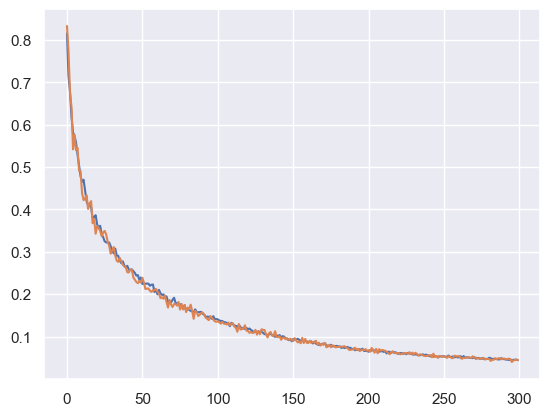

In [13]:
sns.lineplot(losses)
sns.lineplot(val_losses)

In [14]:
with torch.no_grad():
    val_preds = model(X_test)
    final_val_loss = criterion(val_preds, y_test)
    train_preds = model(X_train)
    final_train_loss = criterion(train_preds, y_train)

# Save model

In [ ]:
# Save pytorch model
curr_time = '{:%Y-%m-%d_%H:%M:%S}'.format(datetime.now())
torch.save(model.state_dict(), f"models/versions/model_{curr_time}.pt")

In [ ]:
# Save config as json
config_path = f'models/configs/{curr_time}.json'
model_config = {
    'learning_rate': 0.001,
    'dropout': 0.4,
    'hidden_sizes': [100, 50],
    'epochs': 300
}
with open(config_path, 'w') as f:
    json.dump(model_config, f)

In [ ]:
# Update model log
config_str = json.dumps(model_config)
row = {
    'datetime': curr_time,
    'params': config_str,
    'train_loss': final_train_loss,
    'val_loss': final_val_loss,
    'notes': 'baseline - good generalization'
}

log_path = 'models/model_versions_log.csv'

with open(log_path, mode='a') as f:
    writer = csv.DictWriter(f, fieldnames=row.keys())
    writer.writerow(row) 

In [149]:
# json.loads(tmp.loc[0, 'params'])